In [1]:
conda install pandas

Channels:
 - defaults
Platform: linux-64
Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/anaconda-panel-2023.05-py310

  added / updated specs:
    - pandas


The following packages will be UPDATED:

  ca-certificates                     2023.08.22-h06a4308_0 --> 2023.12.12-h06a4308_0 
  certifi                         2023.7.22-py311h06a4308_0 --> 2024.2.2-py311h06a4308_0 
  openssl                                 3.0.10-h7f8727e_2 --> 3.0.13-h7f8727e_0 
  pandas                              2.0.3-py311ha02d727_0 --> 2.1.4-py311ha02d727_0 




Preparing transaction: done
Verifying transaction: failed

EnvironmentNotWritableError: The current user does not have write permissions to the target environment.
  environment location: /opt/conda/envs/anaconda-panel-2023.05-py310
  uid: 550114
  gid: 60000



Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd

# NHANES 2017-18 Examination data on Oral Health Dentition in XPT file format
df = pd.read_sas('OHXDEN_J.XPT', format='xport')

# SEQN column is the patient identifier (de-identified of course)
# OHX02CTC to OHX31CTC signify the 28 teeth except the 3rd molars
# Other columns are removed due to non-significance in this study
columns_to_keep = ['SEQN'] + ['OHX{:02d}CTC'.format(i) for i in range(2, 32)]

# Filter DataFrame to keep only the specified columns
df = df[df.columns.intersection(columns_to_keep)]

#Convert it to CSV file to manually check on the dataset
df.to_csv('filtered_dmft.csv', index=False)

In [3]:
df = pd.read_csv('filtered_dmft.csv')

# In this dataset, cells contain capital letters with a letter b in front followed by apostrophes around them
# Define the cleaning function to extract the capital letter only
def clean_strings(cell):
    if isinstance(cell, str):
        return cell.strip().split("'")[1] if "'" in cell else cell
    return cell.decode('utf-8')[2] if isinstance(cell, bytes) else cell

columns_to_clean = df.loc[:, 'OHX02CTC':'OHX31CTC'].columns
df[columns_to_clean] = df[columns_to_clean].applymap(clean_strings)

df.to_csv('cleaned_dmft.csv', index=False)

In [5]:
df = pd.read_csv('cleaned_dmft.csv')

# Define a function to dichotomize the results
def dichotomize(value):
    if pd.isnull(value) or value == ' ':  # Check for missing values or blank spaces
        return ' '  # Represent missing values as blank
    if value in ['D', 'S', 'U']: # According to NHANES these values mean no caries were found
        return '0'  # Absence of caries
    else:
        return '1'  # Presence of caries

tooth_columns = df.loc[:, 'OHX02CTC':'OHX31CTC'].columns
df[tooth_columns] = df[tooth_columns].applymap(dichotomize)

df.to_csv('modified_dmft.csv', index=False)

In [7]:
df = pd.read_csv('modified_dmft.csv')

# Function to apply across the tooth columns to determine dmft value in patients
# DMFT index is used by dental professionals to assess the number of cavities
# It is short for decayed, missing, filed teeth
def calculate_dmft(row):
    if all(pd.isnull(val) or val == ' ' for val in row):
        return ' ' 
    if any(val == '1' for val in row):
        return '1'  
    return '0'  

# Apply the function across the tooth columns to create the dmft column
df['dmft'] = df[tooth_columns].apply(calculate_dmft, axis=1)

# Keep only SEQN and the new dmft column
df_final = df[['SEQN', 'dmft']]

# This dataset shows whether a patient had caries or not
df_final.to_csv('final_dmft.csv', index=False)

In [9]:
# NHANES 2017-18 Demographics data in XPT file format
df = pd.read_sas('DEMO_J.XPT', format='xport')

# Select only the specified columns to be the predictors for our outcome variable
df_filtered = df[['SEQN', 'RIAGENDR', 'RIDAGEYR', 'RIDRETH3', 'DMDEDUC2', 'INDFMPIR']].copy()

# Rename the columns
# These 8 digit codes and their meanings can be found in NHANES
df_filtered.rename(columns={
    'RIAGENDR': 'gender',
    'RIDAGEYR': 'age',
    'RIDRETH3': 'race',
    'DMDEDUC2': 'education',
    'INDFMPIR': 'socioeconomic'
}, inplace=True)

df_filtered.to_csv('filtered_demographics.csv', index=False)

In [11]:
import numpy as np

df = pd.read_csv('filtered_demographics.csv')

# Clean the age column so only adults are included
# This is because DMFT index is usually there for assessing permanent teeth
df['age'] = df['age'].apply(lambda x: np.nan if (isinstance(x, float) and (x < 20 or abs(x - 5.397605346934028e-79) < 1e-9)) else x)

# Combine race categories for easier data analysis
race_mapping = {
    1: 1,  # Mexican American and Other Hispanic combined
    2: 1,  # Mexican American and Other Hispanic combined
    3: 2,  # Non-Hispanic White
    4: 3,  # Non-Hispanic Black
    6: 4,  # Non-Hispanic Asian
    7: 5   # Other Race - Including Multi-Racial
}
df['race'] = df['race'].map(race_mapping)

# Combine education categories for easier data analysis
education_mapping = {
    1: 1,  # Less than 9th grade & 9-11th grade combined
    2: 1,  # Less than 9th grade & 9-11th grade combined
    3: 2,  # High school graduate/GED or equivalent
    4: 2,  # Some college or AA degree
    5: 3,  # College graduate or above
    7: '', # Refused (blank)
    9: ''  # Don't Know (blank)
}
df['education'] = df['education'].map(education_mapping)

# Dichotomize the socioeconomic column
def dichotomize_ses(value):
    if pd.isnull(value) or value == '':  
        return np.nan 
    return 1 if float(value) < 1.00 else 0 # 1.00 is the poverty level defined by NHANES 

df['socioeconomic'] = df['socioeconomic'].apply(dichotomize_ses)

df.to_csv('cleaned_demographics.csv', index=False)

In [27]:
df = pd.read_csv('cleaned_demographics.csv')

# Convert float columns to strings
# Remove redundant decimal points
columns_to_convert = ['dmft', 'gender', 'age', 'socioeconomic', 'education'] 

# Loop through each specified column and convert to integer if the number is whole
for col in columns_to_convert:
    if col in df.columns:
        # Convert to string to replace '.0', then back to numeric if needed.
        # This step ensures that even non-numeric strings are handled.
        df[col] = df[col].apply(lambda x: str(x).replace('.0', '') if pd.notnull(x) else x)

df.to_csv('final_demographics.csv', index=False)

In [29]:
dmft = pd.read_csv('final_dmft.csv')
demographics = pd.read_csv('final_demographics.csv')

# Merge the DataFrames based on the SEQN column
merged = pd.merge(dmft, demographics, on='SEQN')

# Remove the 'SEQN' column
merged.drop(columns=['SEQN'], inplace=True)

merged.to_csv('merged_data.csv', index=False)

In [31]:
merged = pd.read_csv('merged_data.csv', na_values=['', 'NA', 'N/A', ' ', 'NaN', 'missing'])

merged = merged.dropna()

columns_to_convert = ['dmft', 'gender', 'age', 'socioeconomic', 'education'] 

for col in columns_to_convert:
    if col in merged.columns:
        merged[col] = merged[col].apply(lambda x: str(x).replace('.0', '') if pd.notnull(x) else x)

merged.to_csv('final_merged.csv', index=False)

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from tableone import TableOne

df = pd.read_csv('final_merged.csv')
print(df)
print(df.columns)

# Creating Table 1 (summary statistics) using the TableOne library
# Table 1 is very common for healthcare data analysis
T1 = TableOne(df, 
              columns=['gender', 'age', 'race', 'education', 'socioeconomic'], 
              categorical=['gender', 'race', 'education', 'socioeconomic'], 
              groupby='dmft', # dmft is our outcome variable
              pval=True, 
              htest_name=True)

print(T1.tabulate(tablefmt="fancy_grid"))

      dmft  gender  age  race  education  socioeconomic
0        1       2   66     3          1              1
1        0       2   66     4          1              0
2        1       2   75     3          2              1
3        1       1   56     4          3              0
4        1       1   67     2          2              0
...    ...     ...  ...   ...        ...            ...
4393     1       2   31     2          2              0
4394     1       1   33     2          2              0
4395     0       2   70     4          2              1
4396     1       2   41     3          3              0
4397     1       1   38     2          2              0

[4398 rows x 6 columns]
Index(['dmft', 'gender', 'age', 'race', 'education', 'socioeconomic'], dtype='object')
╒══════════════════════╤════╤═══════════╤═════════════╤═════════════╤═════════════╤═══════════╤═══════════════════╕
│                      │    │ Missing   │ Overall     │ 0           │ 1           │ P-Value   │ Test

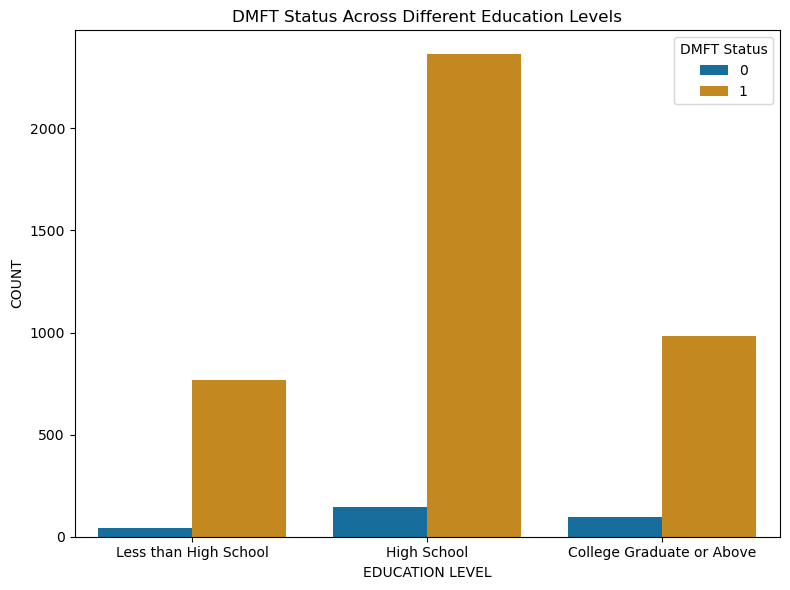

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

merged = pd.read_csv('final_merged.csv')

plt.figure(figsize=(8, 6))

ax = sns.countplot(x='education', hue='dmft', data=merged, palette='colorblind')

ax.set_xticklabels(['Less than High School', 'High School', 'College Graduate or Above'])

plt.title('DMFT Status Across Different Education Levels')
plt.xlabel('EDUCATION LEVEL')
plt.ylabel('COUNT')
plt.legend(title='DMFT Status', loc='upper right')
plt.tight_layout()
plt.show()